In [2]:
import torch
# Import MNIST
from torchvision import datasets
from torchvision.datasets import MNIST

# Define the path to save the dataset
data_path = 'data'
# Download the MNIST dataset
mnist_train = MNIST(root=data_path, train=True, download=True) #建立訓練資料集
mnist_test = MNIST(root=data_path, train=False, download=True) #建立測試資料集
# Print the size of the training and test datasets
print(f"Training dataset size: {len(mnist_train)}")
print(f"Test dataset size: {len(mnist_test)}")
print("MNIST dataset downloaded successfully.")

Training dataset size: 60000
Test dataset size: 10000
MNIST dataset downloaded successfully.


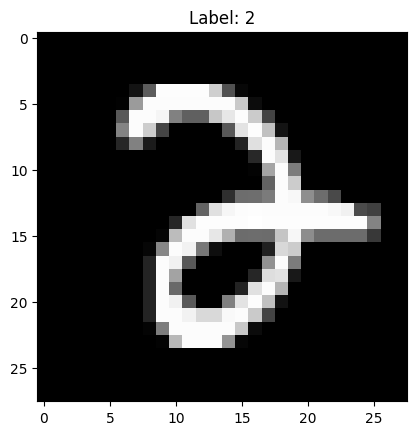

In [3]:
# Print the first image and label
import matplotlib.pyplot as plt
import random
idx = random.randint(0, len(mnist_train) - 1)
plt.imshow(mnist_train.data[idx], cmap='gray')
plt.title(f"Label: {mnist_train.targets[idx]}")
plt.show()

In [4]:
import torch

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            torch.nn.Flatten(), #攤平變成一維
            torch.nn.Linear(64 * 7 * 7, 128), #輸入維度64*7*7，輸出維度128
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )

    def forward(self, x):
        out = self.fc(x)
        return out

# CNN = torch.jit.script(CNN())
# 50epoch 96.75%

In [5]:
from torch.utils.data import TensorDataset, DataLoader

test = torch.tensor(list(range(100)))
test_dataset = TensorDataset(test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for batch, in test_loader:
    print(batch.shape, batch)

# for idx in range(0, len(test), 32):
#     batch = test[idx:idx+32]

torch.Size([32]) tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
torch.Size([32]) tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])
torch.Size([32]) tensor([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])
torch.Size([4]) tensor([96, 97, 98, 99])


In [6]:
Y = torch.tensor([0, 10.0])
print(Y)
print(torch.softmax(Y, dim=0))

torch.exp(Y)/torch.sum(torch.exp(Y))

tensor([ 0., 10.])
tensor([4.5398e-05, 9.9995e-01])


tensor([4.5398e-05, 9.9995e-01])

In [7]:
train_X = mnist_train.data.view(60000, 1, 28, 28).float() / 255.0
train_y = mnist_train.targets
test_X = mnist_test.data.view(10000, 1, 28, 28).float() / 255.0
test_y = mnist_test.targets
# dataloader
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000])
torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [8]:
for batch_X, batch_y in train_loader:
    print(batch_X.shape, batch_y.shape)
    print(torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)(batch_X).shape)
    print(torch.nn.Flatten()(batch_X).shape)
    print(torch.nn.Flatten()(torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)(batch_X)).shape)
    
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 32, 28, 28])
torch.Size([64, 784])
torch.Size([64, 25088])


In [9]:
from tqdm import tqdm
# Train the model
model = CNN()
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(50):
    total_loss = 0.0
    total_hit = 0
    for batch_X, batch_y in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        # print(batch_X.shape, batch_y.shape)
        # torch.Size([64, 784]) torch.Size([64])
        outputs = model(batch_X)
        # print(outputs.shape, batch_y.shape)
        # torch.Size([64, 10]) torch.Size([64])
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_hit += torch.sum(batch_y == torch.argmax(outputs, dim=1)).item()
    train_loss = total_loss / len(train_loader)
    train_accuracy = total_hit / len(train_loader.dataset)

    # Validation
    total_loss = 0.0
    total_hit = 0
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, total=len(test_loader)):
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            total_hit += torch.sum(batch_y == torch.argmax(outputs, dim=1)).item()
    test_loss = total_loss / len(test_loader)
    test_accuracy = total_hit / len(test_loader.dataset)

    print(f"Epoch [{epoch+1:3d}/100], Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f} Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}")


 69%|██████▊   | 644/938 [00:10<00:04, 63.86it/s]


KeyboardInterrupt: 

In [26]:
pred_Y = torch.argmax(outputs, dim=1)
print(pred_Y)
print(batch_y)

print(torch.sum(batch_y == pred_Y) / len(batch_y))

tensor([1, 7, 9, 6, 9, 8, 3, 7, 0, 7, 5, 5, 2, 9, 9, 3, 5, 5, 1, 0, 0, 0, 8, 8,
        2, 8, 0, 0, 9, 0, 0, 2, 4, 8, 3, 9, 9, 1, 7, 0, 0, 2, 8, 5, 1, 7, 2, 0,
        1, 0, 0, 4, 6, 2, 5, 0, 2, 5, 6, 6, 5, 1, 9, 6])
tensor([1, 7, 7, 6, 9, 8, 3, 7, 0, 7, 8, 0, 2, 9, 9, 3, 5, 5, 1, 3, 0, 0, 8, 8,
        2, 8, 0, 0, 7, 0, 0, 2, 4, 8, 3, 9, 9, 1, 7, 0, 0, 2, 8, 1, 1, 7, 0, 8,
        1, 0, 0, 4, 6, 2, 5, 0, 2, 5, 6, 6, 8, 1, 4, 6])
tensor(0.8438)
